In [1]:
%load_ext autoreload
import ddls

Initialise what type(s) of nodes (servers) you want in your cluster and what type(s) of worker(s) you want to populate them with.

In [2]:
%autoreload
from ddls.devices.processors.gpus.A100 import A100

import json


node_config = {'type_1':
                  {
                      'num_nodes': 16,
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
                               'worker': A100
                              }
                          ]
                  }
              }

print(node_config)

{'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


Initialise the topology to be populated by your nodes.

In [3]:
topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4,
                          'y_dims': 4
                      }
                  }

Initialise the cluster environment using your node and topology configuration.

----done
Cluster <class 'ddls.clusters.cluster.Cluster'> | Topology: <class 'ddls.topologies.torus.Torus'> with 16 nodes and 32 | Topology config: {'type': 'torus', 'kwargs': {'x_dims': 4, 'y_dims': 4}} | Node config: {'type_1': {'num_nodes': 16, 'workers_config': [{'num_workers': 4, 'worker': <class 'ddls.devices.processors.gpus.A100.A100'>}]}}


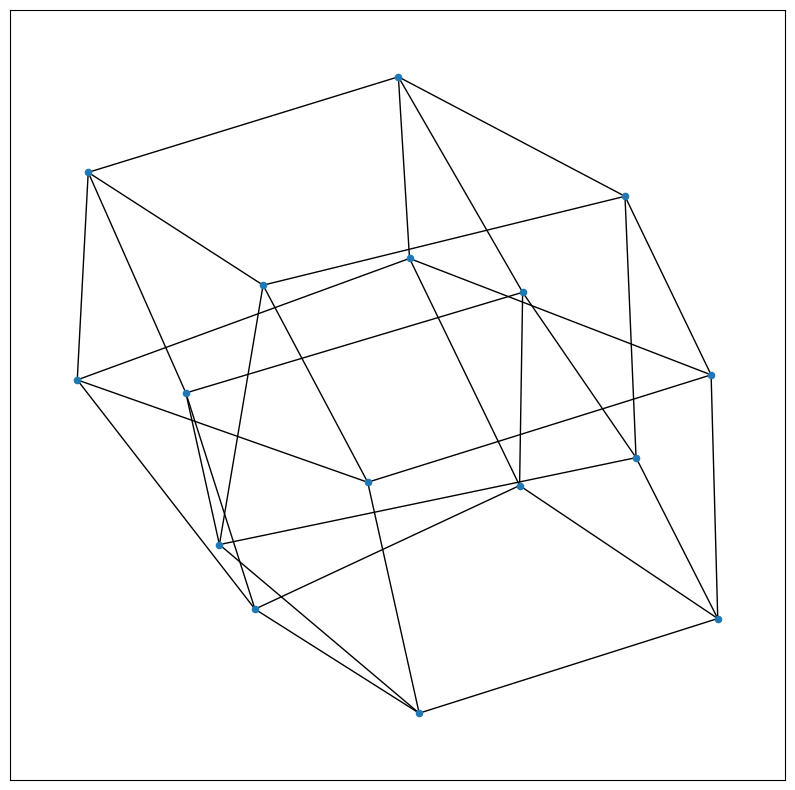

Node 1-1-1: {'workers': {140182201617424: <ddls.devices.processors.gpus.A100.A100 object at 0x7f7eb654cc10>, 140182642679328: <ddls.devices.processors.gpus.A100.A100 object at 0x7f7ed09ede20>, 140182201617664: <ddls.devices.processors.gpus.A100.A100 object at 0x7f7eb654cd00>, 140182201615552: <ddls.devices.processors.gpus.A100.A100 object at 0x7f7eb654c4c0>}}
Node 2-1-1: {'workers': {140182201617616: <ddls.devices.processors.gpus.A100.A100 object at 0x7f7eb654ccd0>, 140182902800288: <ddls.devices.processors.gpus.A100.A100 object at 0x7f7ee01fffa0>, 140182201617808: <ddls.devices.processors.gpus.A100.A100 object at 0x7f7eb654cd90>, 140182201617856: <ddls.devices.processors.gpus.A100.A100 object at 0x7f7eb654cdc0>}}
Node 3-1-1: {'workers': {140182201617712: <ddls.devices.processors.gpus.A100.A100 object at 0x7f7eb654cd30>, 140182201617760: <ddls.devices.processors.gpus.A100.A100 object at 0x7f7eb654cd60>, 140182201617952: <ddls.devices.processors.gpus.A100.A100 object at 0x7f7eb654ce20>,

In [4]:
%autoreload
from ddls.clusters.cluster import Cluster

env = Cluster(topology_config=topology_config,
              node_config=node_config)
print(env)
env.topology.render()

for node in env.topology.graph:
    print(f'Node {node}: {env.topology.graph.nodes[node]}')

Load the `ddls` computation graph(s) you want to run on the cluster.

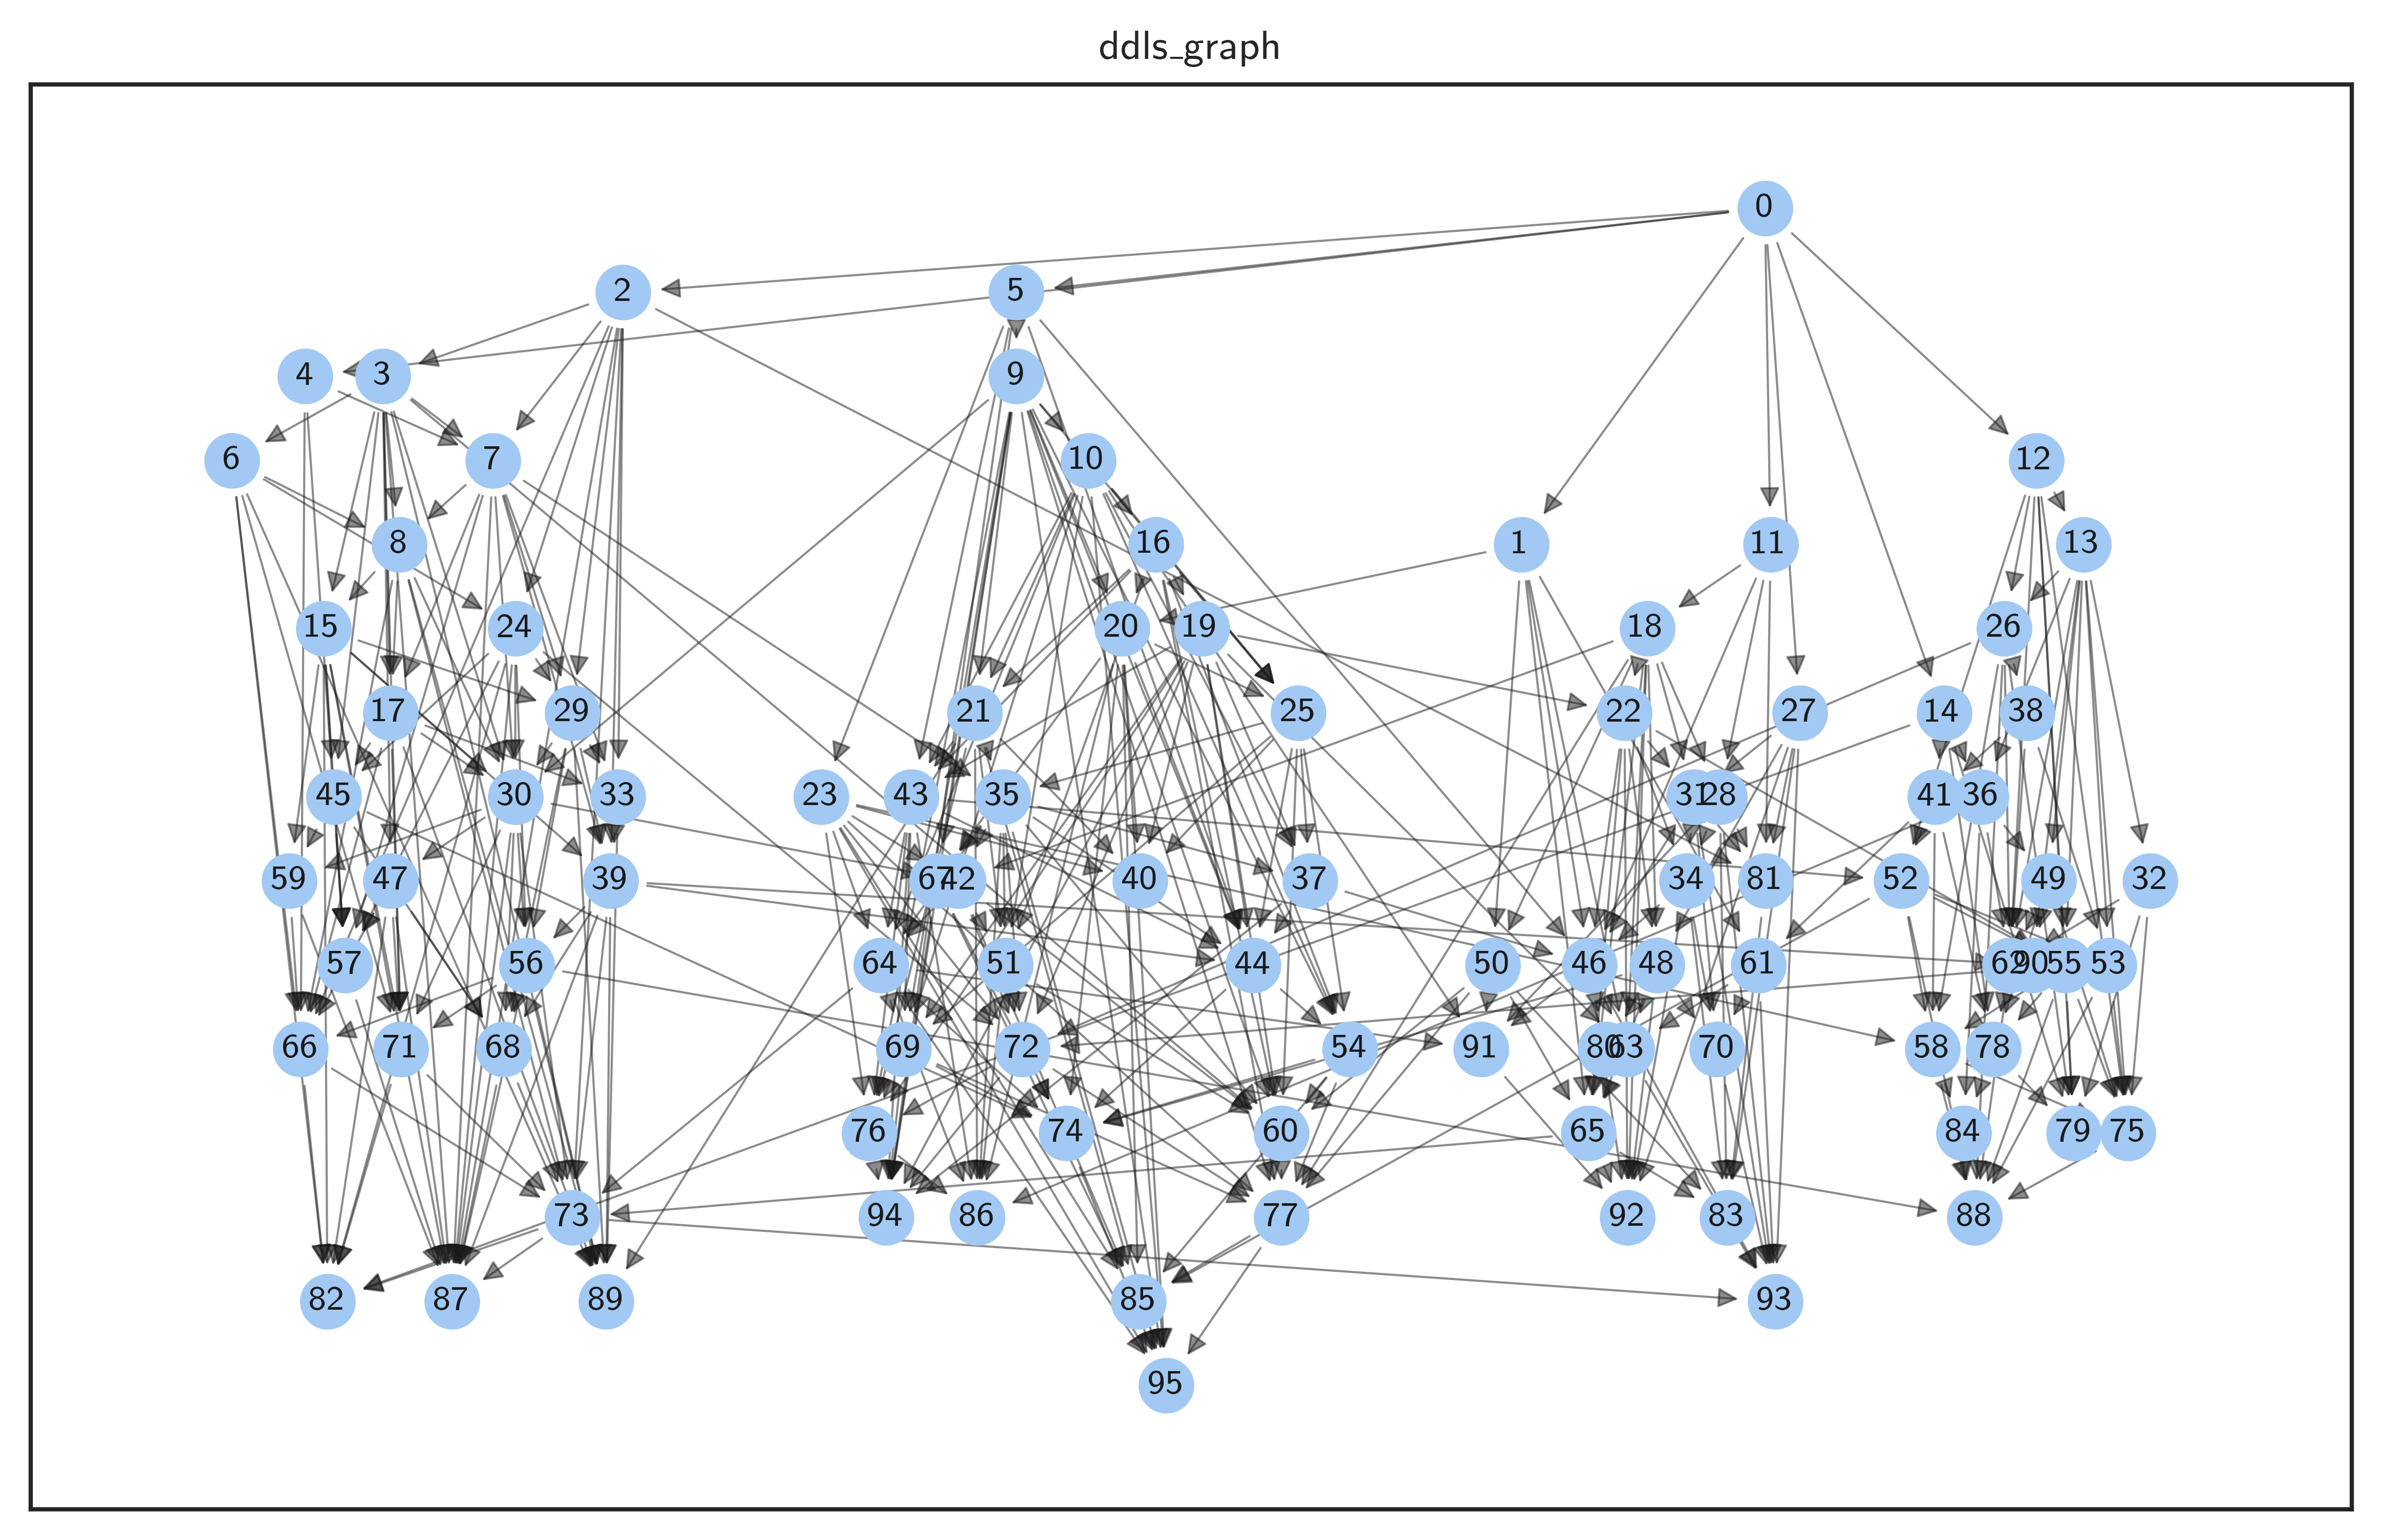

Constructed figure in 7.321 s


In [5]:
%autoreload
from ddls.utils import ddls_graph_from_pbtxt_file
from ddls.plotting.plotting import plot_computation_graph

import glob


# get file paths
path_to_files = '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid'
file_paths = glob.glob(path_to_files + '/*')
    
# create ddls graph
ddls_computation_graph = ddls_graph_from_pbtxt_file(file_paths[0], processor_type_profiled='A100', verbose=False)

# visualise
fig = plot_computation_graph(ddls_computation_graph, scaling_factor=3, title='ddls_graph', show_fig=True, verbose=True)

Initialise `ddls` job(s) from the computation graph(s)

In [6]:
%autoreload
from ddls.demands.jobs.job import Job

jobs = [Job(computation_graph=ddls_computation_graph,
            num_training_steps=1)]

for job in jobs:
    print(job)

Job ID: 140181919231184 | # nodes: 96 | # edges: 410 | # training steps: 1 | Total op mem cost: 0 | Total dep size: 13895


Initialise an operation placement agent.

In [7]:
%autoreload
from ddls.managers.placers.random_job_placer import RandomJobPlacer
from ddls.managers.schedulers.srpt_job_scheduler import SRPTJobScheduler

control_plane = {
    'job_placer': RandomJobPlacer(),
    'job_scheduler': SRPTJobScheduler()
}

Reset cluster environment

In [8]:
%autoreload
from ddls.distributions.uniform import Uniform

obs, action_set, reward, done, info = env.reset(jobs=jobs,
                                                job_sampling_mode='remove',
                                                job_interarrival_time_dist=Uniform(min_val=1, max_val=10),
                                                max_simulation_run_time=100,
                                                job_queue_capacity=1,
                                                verbose=True)

Reset cluster environment.
Job interarrival time dist: Distribution type: <class 'ddls.distributions.uniform.Uniform'> | min_val: 1 | max_val: 10 | interval: 1 | decimals: 10
Job sampler: Original pool: [<ddls.demands.jobs.job.Job object at 0x7f7ea57fecd0>] | Current pool: [] | Sampling mode: remove
Max sim run time: 100


**TODO**: Implement logic for placing job ops of each job -> step env -> time job completion for 1 training step (can then think about $n$ training steps, network communication overhead, etc.)

- Have mounted job onto devices
- Now need to work out way of tracking ops running on each device efficiently and timing how long they take. Consider having global dict tracking operations which are running to avoid having to keep looping through all ops to check dependencies. Consider also having stopwatch object similar to Noah's where only tick it when have stacked enough sequential operations. N.B. Think should assume that, once ops have been placed on a device, they must be ran sequentially (i.e. cannot run multiple ops on one device at the same time; assume time profile is for e.g. GPU worker running just that one op with <= all its cores)

In [16]:
%autoreload
import pprint

while not done:
    # make decisions
    actions = {}
    actions['job_placement'] = control_plane['job_placer'].get_placement(jobs=env.job_queue.jobs.values(), cluster=env)
    actions['job_schedule'] = control_plane['job_scheduler'].get_schedule(jobs=env.job_queue.jobs.values(), placement=actions['job_placement'], worker_to_type=env.topology.graph.graph['worker_to_type'])
    pprint.pprint(actions)
#     print(actions)
    
    # pass actions to cluster environment and move to next step
    obs, action_set, reward, done, info = env.step(actions, verbose=True)
    
    raise Exception()

{'140181919231184_0': None, '140181919231184_7': None, '140181919231184_9': None}


TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:
a = '8_10_11'
print(a.split('_'))

In [ ]:
for i in range(0):
    print(i)